In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print(f"Using {device} device")

Using cuda device


In [3]:
!nvidia-smi

Mon Apr 24 13:51:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
transform = transforms.Compose([transforms.Resize((227,227)),transforms.ToTensor(),normalize])

In [5]:
data_train = datasets.CIFAR10(root = "./data/", transform=transform, train = True, download = True)

data_test = datasets.CIFAR10(root="./data/", transform = transform, train = False, download = True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12985785.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [6]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size = 64, shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size = 64, shuffle = True)

In [7]:
print(len(data_train))
print(len(data_test))
print(len(data_loader_train))
print(len(data_loader_test))

50000
10000
782
157


In [8]:
img, label = data_train[1]
print(img.shape)
print(label)

torch.Size([3, 227, 227])
9


In [9]:
class AlexNet(nn.Module):
  #  Inherits nn.Module as it contains many of the methods that we will need to utilize.

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Initializing the layers that we are going to use in our CNN --

        self.layer1 = nn.Sequential(
            # define the convolutional layers using the nn.Conv2D function with the appropriate kernel size and the input/output channels.
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))  # apply max pooling using nn.MaxPool2D function.

        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # Now, define the fully connected layers :
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)) # Output has 10 classes here in cifar-10 dataset.

    #  Now, define the sequence in which these above layers will process the image--  
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [10]:
from torchsummary import summary

model = AlexNet(num_classes=10)
summary(model, (3, 227, 227), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

In [11]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=ecf324e5a3494b62ae3fea9e104b028a0ee25dcaec63448019dd0c534aabe173
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


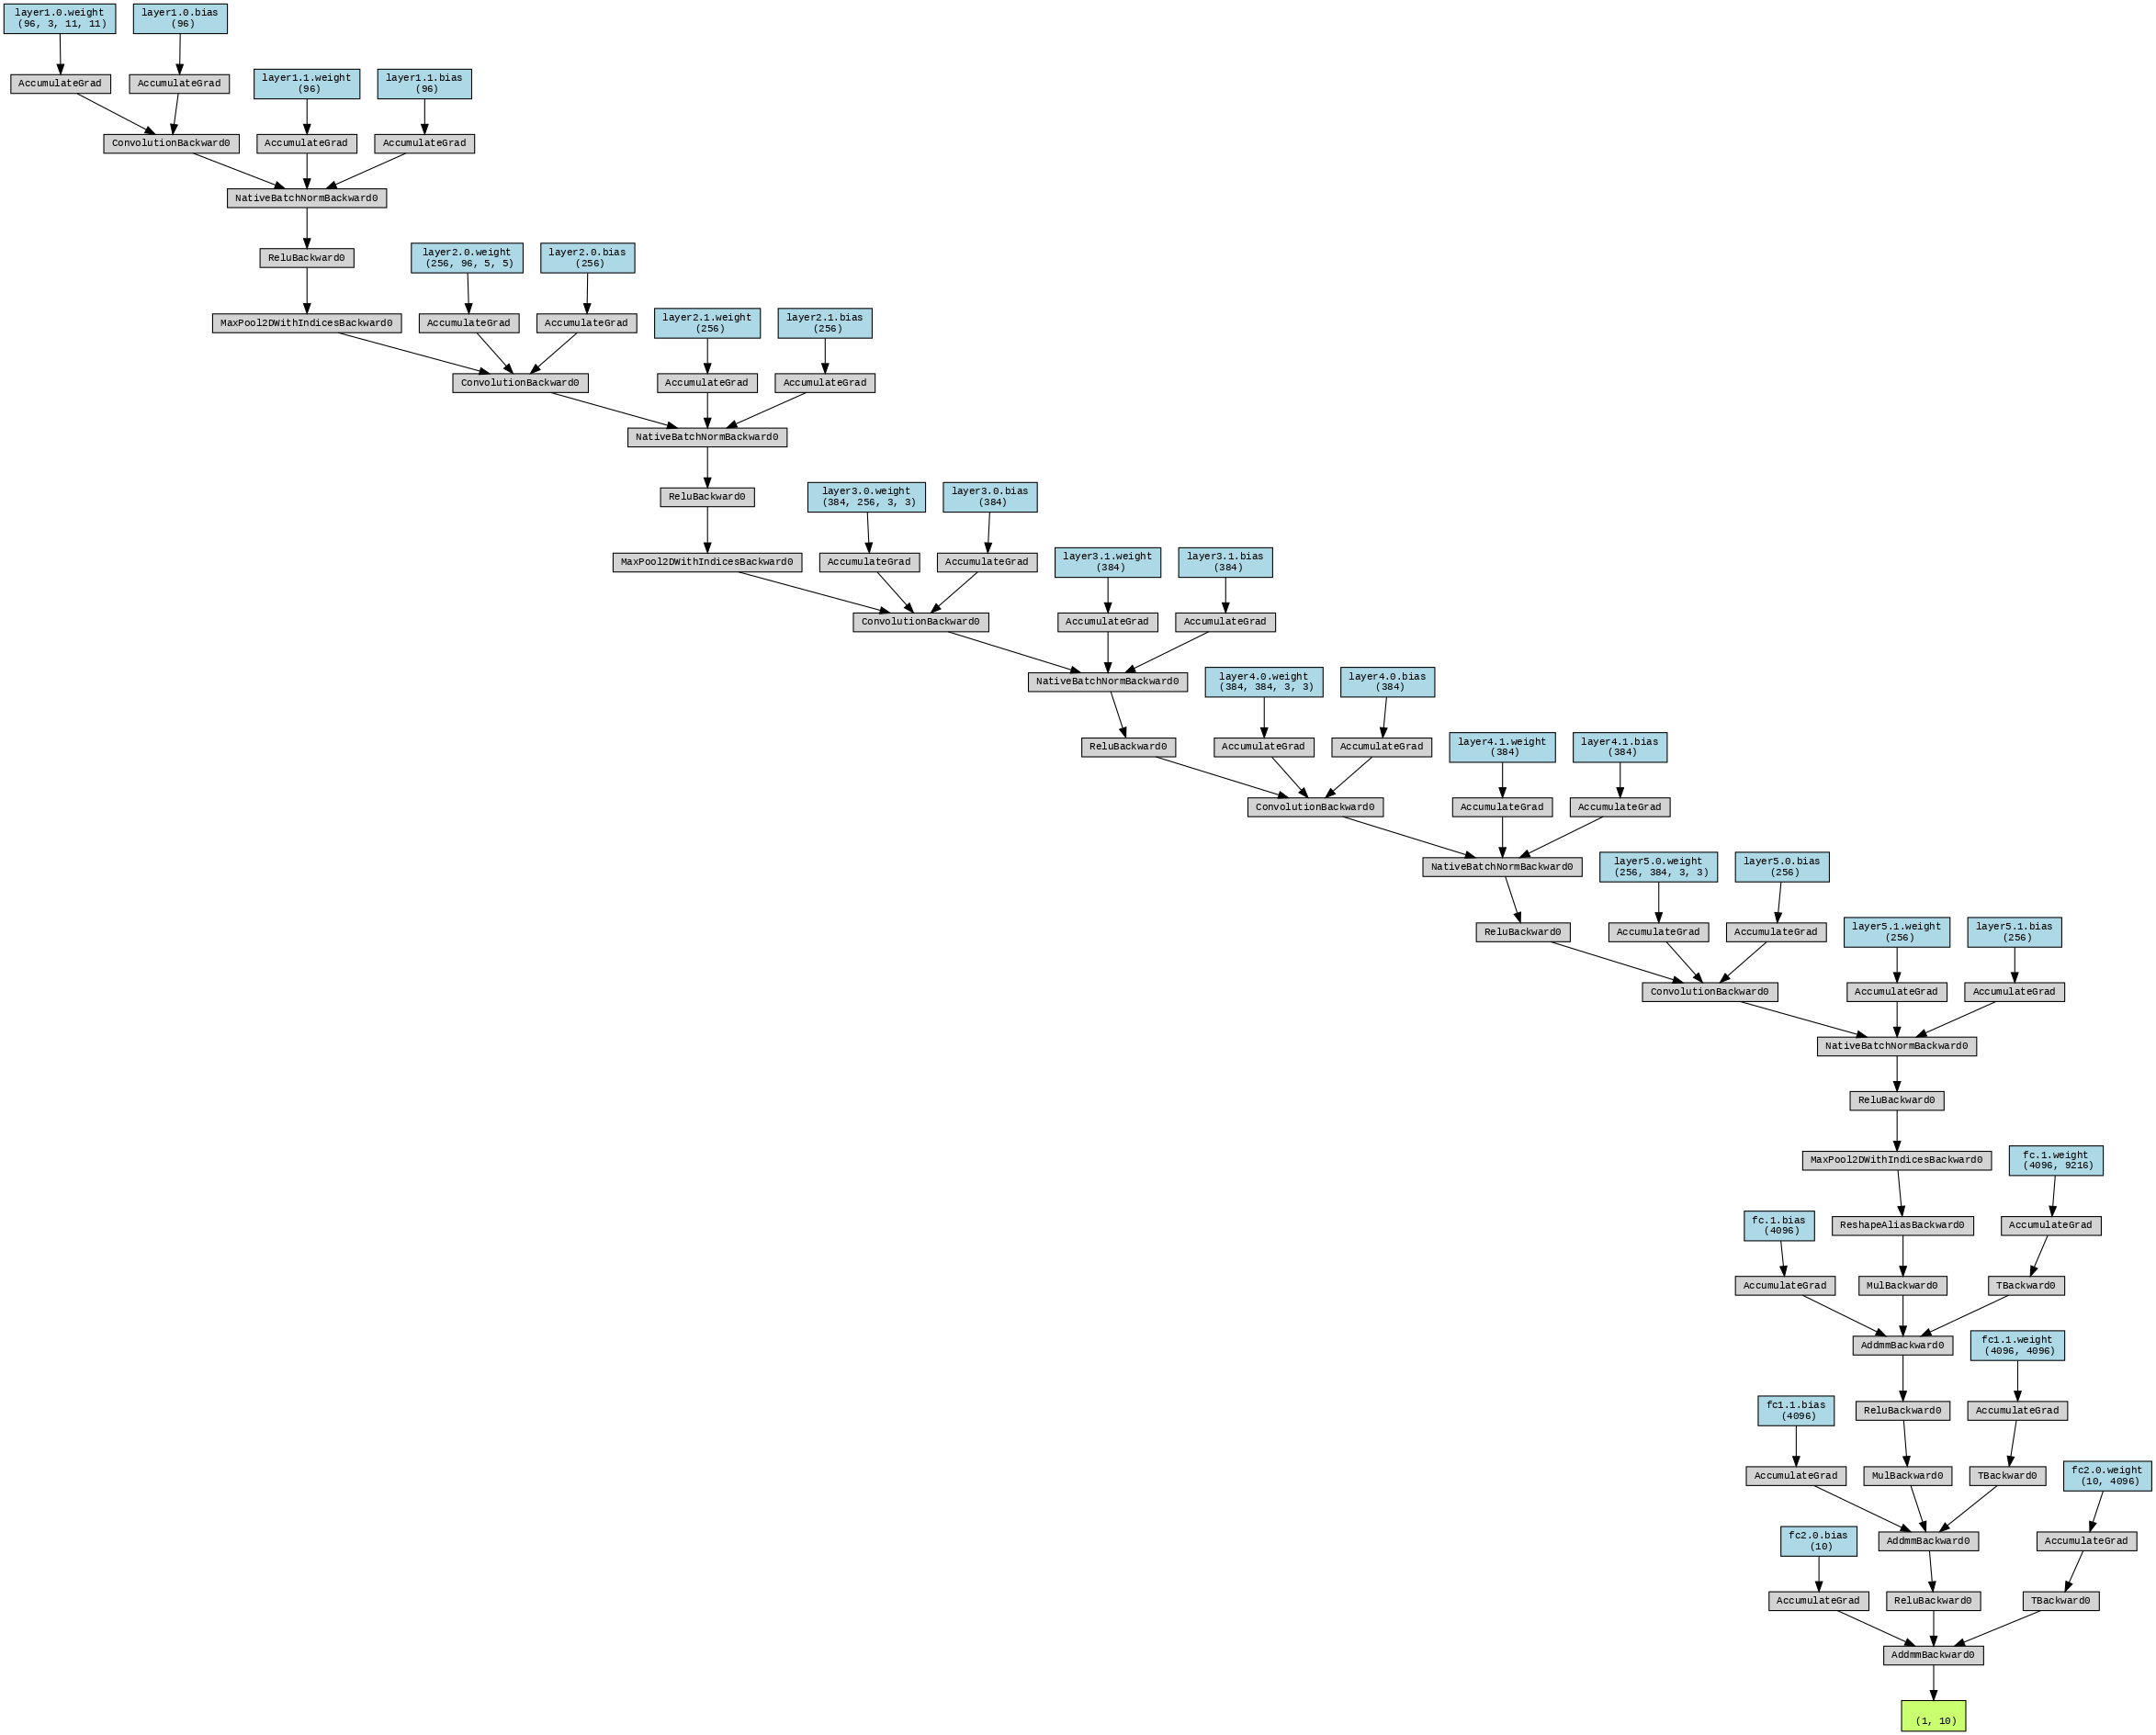

In [13]:
from torchviz import make_dot
from IPython.display import Image
# # Create a random input tensor
x = torch.randn(1, 3, 227, 227)

# Use make_dot to visualize the network graph
dot = make_dot(model(x), params=dict(model.named_parameters()))
# dot.render('alexnet', format='png')
dot.format = 'png'
dot.render('alexnet')

# Display the image in Jupyter Notebook
Image(filename='alexnet.png')

In [14]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(data_loader_train) # define total_step to keep better track of steps when training

In [15]:
from sklearn.metrics import f1_score

def compute_f1_score(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    score = f1_score(y_true, y_pred, average='macro')
    return score


## Training and Testing

In [16]:
# total_step = len(data_loader_train)
# Train_Accuracy = []
# Test_Accuracy = []

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     running_correct = 0
#     cnt = 0

#   # start by iterating through the number of epochs, and then the batches in our training data:
#     for i, (images, labels) in enumerate(data_loader_train):  

#         # Move tensors to the configured device
#         images = images.to(device)   # convert images to devices a/c to CPU or GPU
#         labels = labels.to(device)  # convert labels to devices a/c to CPU or GPU
        
#         # Forward pass
#         outputs = model(images)  #  make predictions using our model and 
#         _, pred = torch.max(outputs.data, 1)

#         loss = criterion(outputs, labels) # calculate loss based on those predictions and our actual labels.
        
#         # Backward and optimize  -- update our weights to improve our model
#         optimizer.zero_grad()   # set the gradients to zero before every update

#         cnt += 1
#         running_loss = running_loss + loss.data
#         running_correct += (pred == labels).sum().item()
#         print("[E: %d] loss: %f, avg_loss: %f" % (epoch, loss.data, running_loss/cnt))
#         loss.backward()  #  calculate the new gradients
#         optimizer.step()  # update the weights

#     # Compute F1-score after every 5 epochs
#     if epoch % 5 == 4:
#         train_f1_score = compute_f1_score(model, data_loader_train)
#         test_f1_score = compute_f1_score(model, data_loader_test)
#         print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%, Train F1-score: {:.4f}, Test F1-score: {:.4f}"
#               .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test), train_f1_score, test_f1_score))
        
#     # Evaluate model on test set
#     testing_correct = 0
#     with torch.no_grad():
#       # we don't need gradients so we use with torch.no_grad() for faster evaluation
#         correct = 0
#         total = 0
#         for images, labels in data_loader_test:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             testing_correct += (predicted == labels).sum().item()
#             correct += (predicted == labels).sum().item()
#             del images, labels, outputs
    
#         print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
#                                                                                       100*running_correct/len(data_train),
#                                                                                       100*testing_correct/len(data_test)))
#         Train_Accuracy.append(running_correct/len(data_train))
#         Test_Accuracy.append(testing_correct/len(data_test))

# torch.save(model.state_dict(), "/content/model_parameter.pth")

In [17]:
total_step = len(data_loader_train)
Train_Accuracy = []
Test_Accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    cnt = 0

    # start by iterating through the number of epochs, and then the batches in our training data:
    for i, (images, labels) in enumerate(data_loader_train):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        cnt += 1
        running_loss = running_loss + loss.data
        running_correct += (pred == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    # Compute F1-score after every 5 epochs
    if epoch % 5 == 4:
        train_f1_score = compute_f1_score(model, data_loader_train)
        test_f1_score = compute_f1_score(model, data_loader_test)
        print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%, Train F1-score: {:.4f}, Test F1-score: {:.4f}"
              .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test), train_f1_score, test_f1_score))

    # Evaluate model on test set
    testing_correct = 0
    with torch.no_grad():
        for images, labels in data_loader_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            testing_correct += (predicted == labels).sum().item()

    # Compute and print training and testing accuracy
    print("Epoch [{}/{}], Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%"
          .format(epoch+1, num_epochs, 100*running_correct/len(data_train), 100*testing_correct/len(data_test)))

    Train_Accuracy.append(running_correct/len(data_train))
    Test_Accuracy.append(testing_correct/len(data_test))

torch.save(model.state_dict(), "/content/model_parameter.pth")


Epoch [1/10], Train Accuracy: 50.02%, Test Accuracy: 59.72%
Epoch [2/10], Train Accuracy: 66.68%, Test Accuracy: 69.33%
Epoch [3/10], Train Accuracy: 72.42%, Test Accuracy: 73.37%
Epoch [4/10], Train Accuracy: 75.68%, Test Accuracy: 75.73%
Epoch [5/10], Train Accuracy: 78.13%, Test Accuracy: 75.73%, Train F1-score: 0.8009, Test F1-score: 0.7688
Epoch [5/10], Train Accuracy: 78.13%, Test Accuracy: 77.23%
Epoch [6/10], Train Accuracy: 77.96%, Test Accuracy: 74.42%
Epoch [7/10], Train Accuracy: 81.45%, Test Accuracy: 79.09%
Epoch [8/10], Train Accuracy: 83.37%, Test Accuracy: 79.60%
Epoch [9/10], Train Accuracy: 84.27%, Test Accuracy: 81.03%
Epoch [10/10], Train Accuracy: 85.33%, Test Accuracy: 81.03%, Train F1-score: 0.8664, Test F1-score: 0.8062
Epoch [10/10], Train Accuracy: 85.33%, Test Accuracy: 80.33%


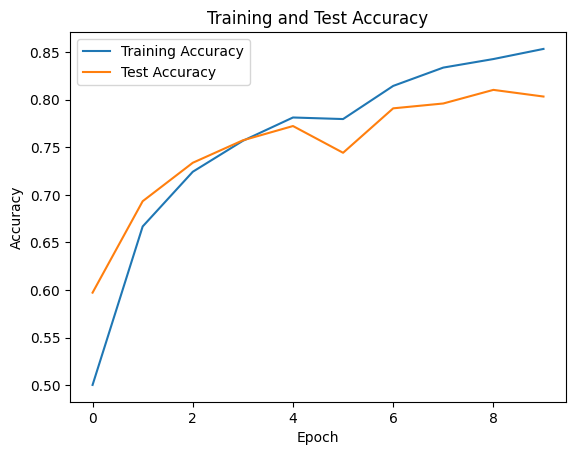

In [18]:
plt.plot(range(num_epochs), Train_Accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), Test_Accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

`After-5 Epoch:`

    `Train F1-score: 0.8009, Test F1-score: 0.7688`

`After 10th Epoch:`

    `Train F1-score: 0.8664, Test F1-score: 0.8062`

END